# Exercise Session 1: Getting Started with Computer Vision

The goals of this exercise are:
* getting started with Python for image manipulation
* getting familiar with the basic image manipulation functions
* implementing some simple real-world Computer Vision algorithms

In [126]:
%matplotlib inline
import glob
import numpy as np
import matplotlib.pyplot as plt

import imageio
import cv2

from skimage import measure, color
from os import listdir 

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

If you have some missing packages, you can use the corresponding ```conda install``` command from below list to install it,

In [108]:
conda install -c conda-forge scikit-image
conda install -c conda-forge matplotlib
conda install -c conda-forge opencv
conda install -c anaconda numpy

SyntaxError: invalid syntax (<ipython-input-108-b09939b1e4d8>, line 1)

## Exercise 1: Image Segmentation

In many vision applications, it is useful to separate out the regions of the image corresponding to objects in which we are interested in the regions of the image that correspond to the background. Thresholding often provides an easy and convenient way to perform this segmentation on the basis of the different intensities or colours in the foreground and background regions of an image.

The input to a thresholding operation is typically a grayscale or colour image. In the simplest implementation, the output is a binary image representing the segmentation. Black pixels correspond to background and white pixels correspond to foreground (or vice versa). Multiple thresholds can be specified, so that a band of intensity values can be set to white while everything else is set to black.

If it is possible to separate out the foreground of an image on the basis of pixel intensity, then the intensity of pixels within foreground objects must be distinctly different from the intensity of pixels within the background. In this case, we expect to see a distinct peak in the histogram corresponding to foreground objects such that thresholds can be chosen to isolate this peak accordingly. If such a peak does not exist, then it is unlikely that simple thresholding will produce a good segmentation.
 


* Read and display the image "wdg.png" using function ```cv2.imread()```. Convert it from color to greyscale if necessary using function ```cv2.cvtColor()```. Visualize the results using ```plt.imshow()``` function.</li>

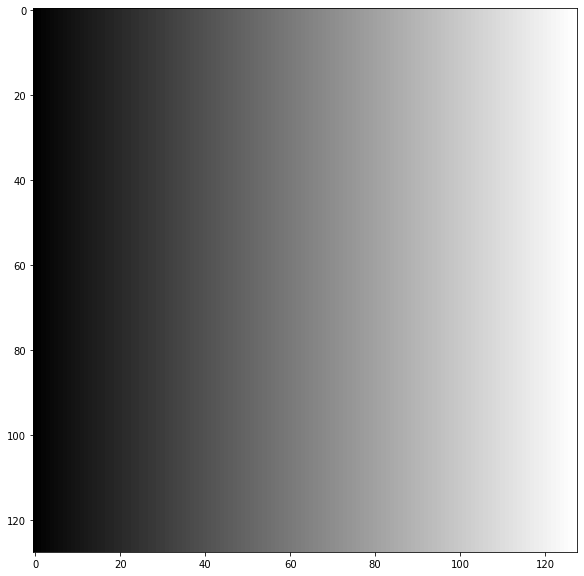

In [109]:
#add your code here
img = cv2.imread('images/shading.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img) 

* Write a function to threshold a gray scale image by using two threshold values as shown above. The values must satisfy the following conditions:
\begin{align}
Th1 < Th2 
\newline 
Th1 > 0 
\newline 
Th2 < I_{max}
\end{align}
where $I_{max}$ is the maximum intensity of the image.

In [110]:
#add your code here
def threshold(img, Tmin=np.min(img), Tmax=np.max(img)):

    img[img < Tmin] = 0  # black
    img[img > Tmax] = 0
    img[img != 0] = 255  # white
    
    return img

* Take a look at the pixels intensity histogram using function ```matplotlib.pyplot.hist()``` and choose the best threshold values and segment the image.</li>

(array([[128.,   0.,   0., ...,   0.,   0.,   0.],
        [128.,   0.,   0., ...,   0.,   0.,   0.],
        [128.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0., 128.],
        [  0.,   0.,   0., ...,   0.,   0., 128.],
        [  0.,   0.,   0., ...,   0.,   0., 128.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 128 BarContainer objects>)

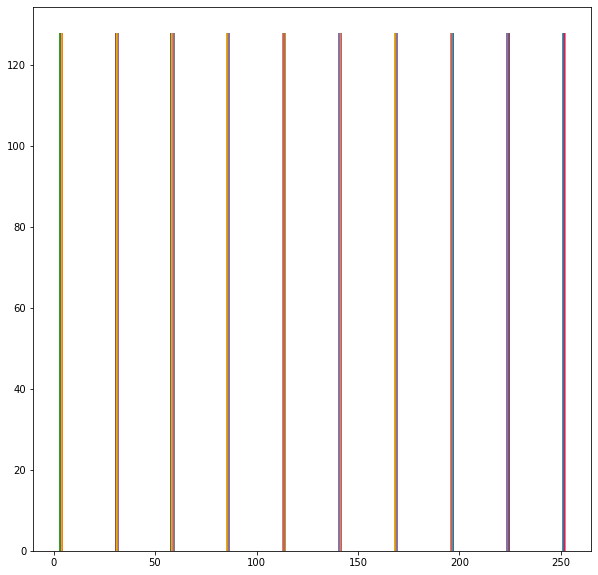

In [111]:
#add your code here
plt.hist(img)

* Repeat the same steps for images "brain.png" and "shading.png". What do you notice? What are the drawbacks of this segmentation method? </li>

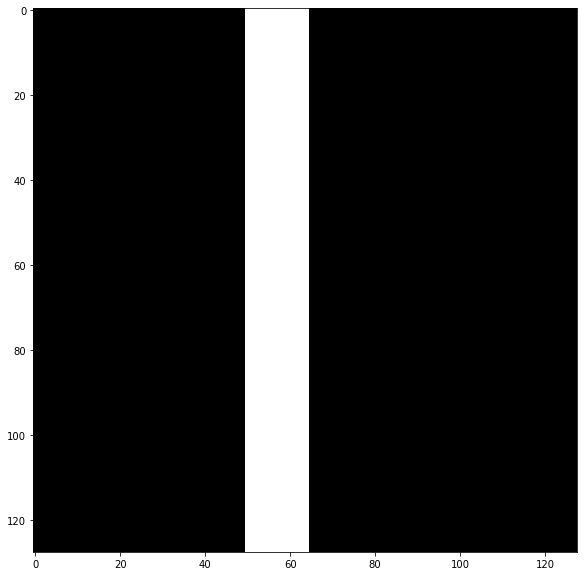

In [112]:
#add your code here
img = threshold(img, 100, 130)
plt.imshow(img)

## Exercise 2: Background Substraction

Background subtraction is an important preprocessing step of many algorithms, e.g. object detection. In the following exercises we will try to subtract the scene background using multiple images.

### 2.1 Extracting a moving object

* Load the "street1.tiff" and the "street2.tiff" images. Visualize them.

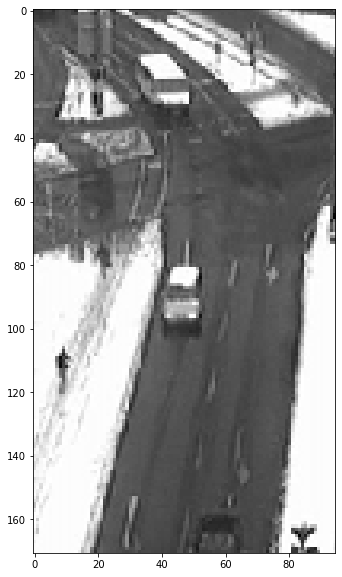

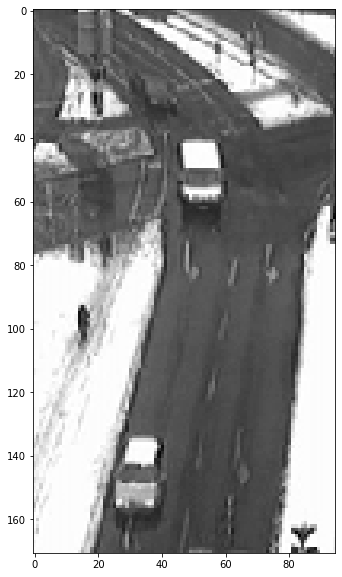

In [113]:
#add your code here.  
st1 = cv2.imread('images/street1.tiff', cv2.IMREAD_GRAYSCALE)
st2 = cv2.imread('images/street2.tiff', cv2.IMREAD_GRAYSCALE)

plt.imshow(st1); plt.show(); plt.imshow(st2)

* Transform the 8-bit images into float images. You can use image attribute ```dtype``` to check the type of image. To perform the type casting you can use ```np.float32()``` function. 

In [114]:
#add your code here. 
st1f = np.float32(st1)
st2f = np.float32(st2)

* Subtract the second image from the first one using basic matrix arithmetic operations. Visualize the results. Why was it important to do the casting before subtracting the images? 

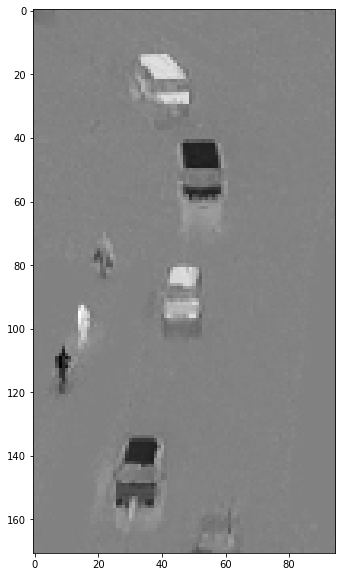

In [115]:
# add your code here. Assign the difference to 'image_diff'
image_diff = st1f-st2f
plt.imshow(image_diff)  

### 2.2 Building a background model
For this exercise, you are given a sequence of images that contains pedestrians and we wish to segment with a background subtraction algorithm.

* Load and create a stack of images from the images inside ```images/sequence1```. Build a "background model" by averaging out the set of given images. Detect pedestrians
 subtracting the background model from the original images and applying the right threshold.

Text(0.5, 1.0, 'Background model')

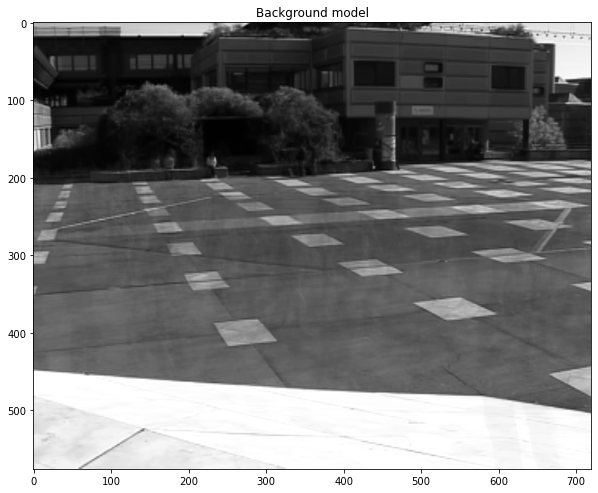

In [139]:
sq_of_images = listdir('images/sequence1/')  
sq_of_images = [img for img in sq_of_images if img.endswith(".jpg")]
# 'sq_of_images' holds the list of image names. Create an image stack using them.
img_stack = np.stack([cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob("images/sequence1/*.jpg")])  # shape: imageNumber x imageSize

# Compute the mean image using the stack and assign it to 'mean_image'.
mean_image = np.mean(img_stack, axis=0)
plt.imshow(mean_image) 
plt.title('Background model')

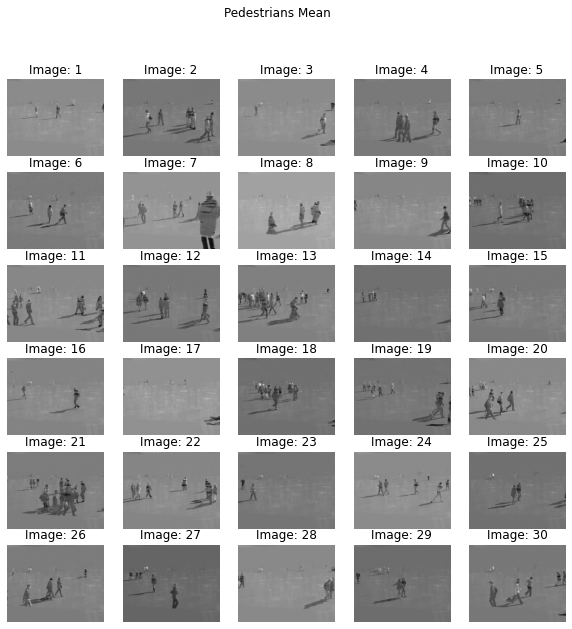

In [143]:
T = 0.1 
plt.figure(2)
plt.suptitle('Pedestrians Mean')

# First convert the mean image to grayscale.
# When subtracting, each image must also be converted to grayscale.
for i in range(len(img_stack)):
    # Compute the foreground image here. Assign it to 'foreground' variable.
    foreground = img_stack[i]-mean_image
    
    plt.subplot(6,5,i+1)
    plt.imshow(foreground)
    plt.axis('off')
    plt.title('Image: ' + str(i+1)) 

* Create a more sophisticated background model, where each pixel can be modeled with a Gaussian distribution. We can classify a pixel as background if its current intensity ($I_t$) lies within some confidence interval of its distribution’s mean ($\mu(t)$):


\begin{align}
\frac{\mid{(I_t - \mu_t)}\mid}{\sigma_t} > T \rightarrow Foreground 
\newline
\frac{\mid{(I_t - \mu_t)}\mid}{\sigma_t} < T \rightarrow Background 
\end{align}

$\sigma_t$ is the standard deviation of the pixel $t$ in the background model. $T$ is the threshold.

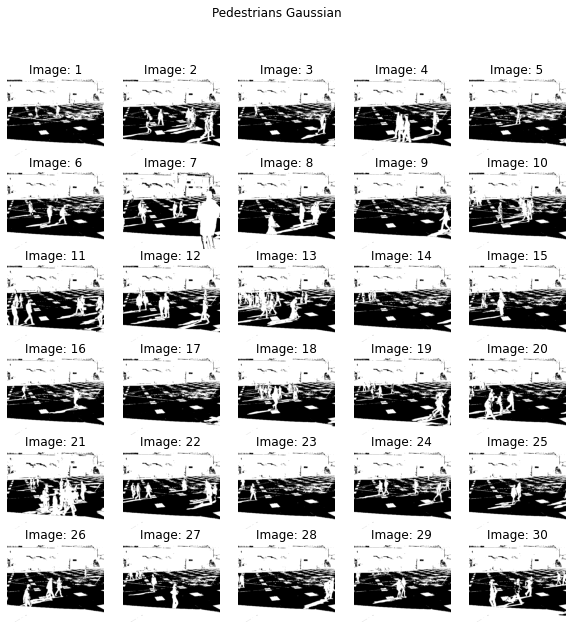

In [151]:
# Add your code here. Before computing the model convert the images into gray-scale images. 
T = 0.4
plt.figure(3)
plt.suptitle('Pedestrians Gaussian')
for i in range(len(img_stack)):
    # Compute the foreground image here. Assign it to 'foreground' variable.
    foreground = np.abs(img_stack[i]-np.mean(img_stack[i]))/np.std(img_stack[i]) > T    
    
    plt.subplot(6,5,i+1)
    plt.imshow(foreground)
    plt.axis('off')
    plt.title('Image: ' + str(i+1)) 

What difference do you notice between the two approaches? How does changing
the threshold affect them?

<i>Comparison between method 1 and 2</i></br>
Visual inspection reveals that the first method performs better when compared with the second method. 
<!--There is more noise especially in the top half of the thresholded images. -->
The reason for this is that in the second model we assume background pixel values belong to a Gaussian distribution but in-reality, they do not, especially in the top half of the images. As a result, more background pixels appear as foreground pixels in the second method. 


<i>Effect of the threshold</i></br>
In both methods, when we increase the threshold, only the pixels that deviate most from the mean model get classified as foreground pixels. As a result, the higher the threshold, the lower the number of foreground pixels. 

## Exercise 3: Connected Components

Segmentation can be also done for colour images. It is also often a first step for the further analysis e.g. measuring properties of the object. Here our goal is to count the number of apples in the image below.



* Read and display"apples.jpg" image.

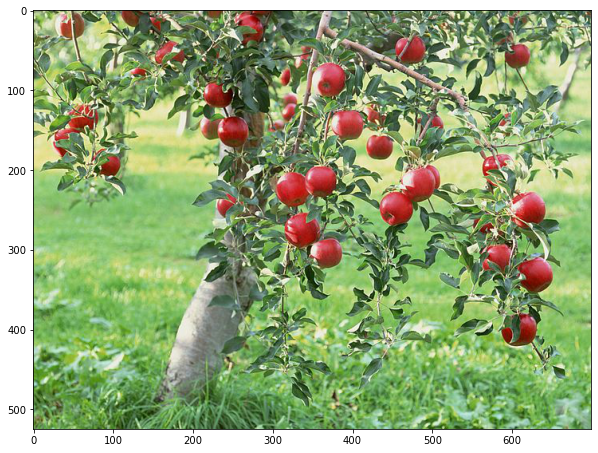

In [183]:
#add your code here
img_apples = cv2.imread('images/apples.jpg', cv2.IMREAD_COLOR)
#Note: OpenCV reads color images in order of BGR (blue, green, red channels) but PyPlot visualizes them as RGB. 
b,g,r = cv2.split(img_apples)       # get b,g,r
img_apples = cv2.merge([r,g,b])     # switch it to rgb
plt.imshow(img_apples)

* Check the size of the image. Compared to the previous images it should have an additional dimension corresponding to three colour channels: red, green and blue. Visualize those 3 channels separately.

Text(0.5, 1.0, 'Blue channel')

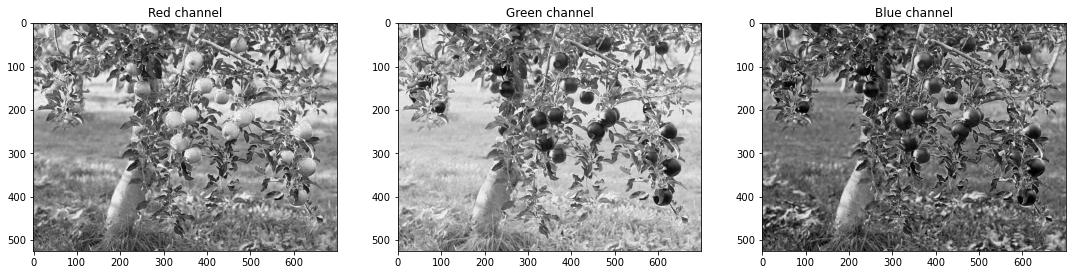

In [184]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)
# add your code for visualizing three channels
axes[0].imshow(img_apples[:,:,0])
axes[0].set_title("Red channel")
axes[1].imshow(img_apples[:,:,1])
axes[1].set_title("Green channel")
axes[2].imshow(img_apples[:,:,2])
axes[2].set_title("Blue channel")

* Try to obtain a binary image such that binary image == 1 for pixels representing apples and 0 otherwise. Which channel(s) would you use for that?

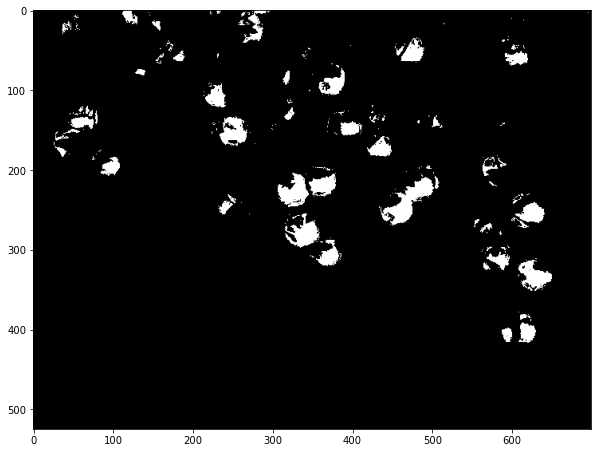

In [209]:
bin_img = np.zeros(img_apples.shape[0:2])
#add your code for thresholding the image
bin_img[(img_apples[:,:,1]<0.25*np.max(img_apples[:,:,1])) & (img_apples[:,:,0]>0.35*np.max(img_apples[:,:,0]))] = 255

# SOLUTIONS
# bin_img[(img_apples[:,:,1]<80) & (img_apples[:,:,0]>100)] = 255
# JEAN LESUR
# green = img_apples[:,:,1]
# ret, thresh = cv2.threshold(green, 57, 255, cv2.THRESH_BINARY_INV)
# bin_img[thresh == 255] = 1

plt.imshow(bin_img)

* Count the number of connected components in your binary image (here corresponding to apples). For this, you can use function ```measure.label()```. Its output is an array of the same size as input binary image, with each pixel assigned to a different connected component (ID). Visualize the image with detected connected components.

In [212]:
#add your code to find connected components
labels = measure.label(bin_img)

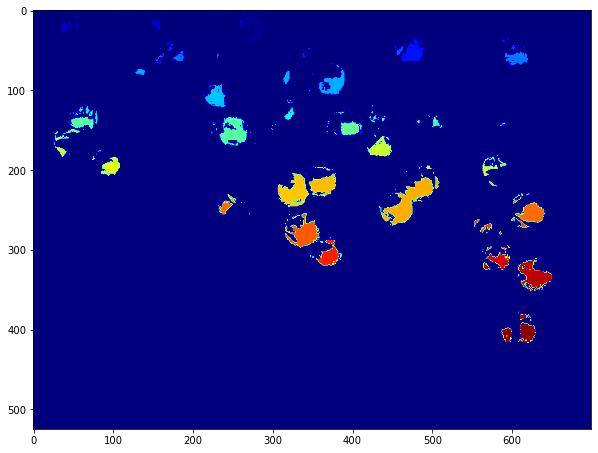

In [213]:
plt.imshow(labels,cmap="jet")

* Simple thresholding sometimes leads to detecting also noise in the background that is detected as seperate connected components. Try to suppress the noise by removing all connected components smaller than a user-defined threshold.

In [214]:
def remove_noise(label_img, threshold):
    # copied from solutions
    label_img_new = np.copy(label_img)
    num_comp = np.amax(label_img)
    
    for i in range(num_comp+1):
        num_pixels = sum(sum(label_img==i))
        if num_pixels < threshold:
            label_img_new[label_img==i] = 0
    
    return label_img_new    

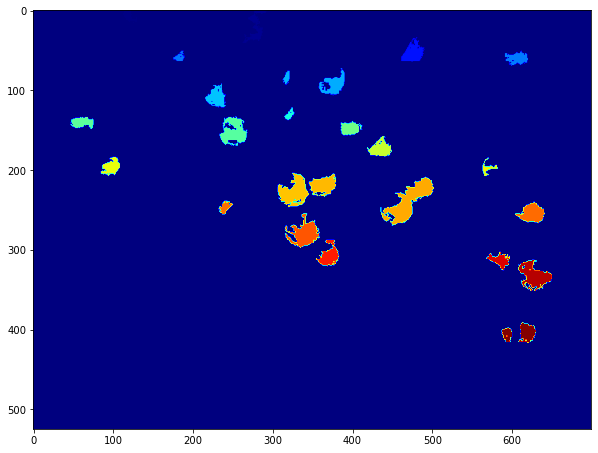

In [216]:
labels_new = remove_noise(labels,80)
plt.imshow(labels_new,cmap="jet")